In [54]:
%load_ext autoreload
%autoreload 2
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time

import librosa
import librosa.display
import sox
import sklearn

import soundfile as sf
import numpy as np
import scipy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from deepafx import dafx_layer
from deepafx import mix_snr
from deepafx import lv2_plugin
from deepafx import utils
from deepafx import layers
from deepafx import models
from deepafx import generators
from deepafx import lee_2020_model as inception

import IPython.display as ipd
import matplotlib

tf.random.set_seed(0)
np.random.seed(0)
# import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['figure.figsize'] = (16,7)
plt.rcParams["axes.facecolor"]= 'w'
plt.rcParams["axes.edgecolor"] = 'k'
plt.rcParams["savefig.dpi"] = 200




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# Loads the parameters for model kModelID and task kTask

kTask = 'nonspeech' # distortion or nonspeech or mastering
kModelID = 1
kIdTrack = 0
kLen = 4 # seconds to plot
kBlockSize = 64 # block size for frames of dafx_smooth

In [56]:
if kTask == 'nonspeech':
    kPathModels = '/home/code-base/scratch_space/models/nonspeech/' 
elif kTask == 'distortion':
    kPathModels = '/home/code-base/scratch_space/models/distortion/' 
elif kTask == 'mastering':
    kPathModels = '/home/code-base/scratch_space/models/mastering/' 

kFullModel = 'full_model_3'  #'full_model_%s' % kModelID
kTestAudio = kPathModels+kFullModel+'results/'

In [57]:
k = np.load(kPathModels+kFullModel+'/'+kFullModel+'.params.npy', allow_pickle=True).item()
for param in k.keys():
    print(param, k[param])

sr 22050
num_samples 40960
batch_size 100
steps_per_epoch 1000
epochs 1000
patience 25
encoder mobilenet
path_audio /home/code-base/scratch_space/nonspeech/daps_22050/
x_recording cleanraw/
y_recording clean/
path_models /home/code-base/scratch_space/models/nonspeech/
output_length 1024
hop_samples 1024
gradient_method spsa
compute_signal_gradient False
multiprocess True
greedy_dafx_pretraining True
default_pretraining True
params [17]
plugin_uri ['http://calf.sourceforge.net/plugins/MultibandGate']
param_map [{0: 19, 1: 20, 2: 21, 3: 31, 4: 32, 5: 33, 6: 43, 7: 44, 8: 45, 9: 55, 10: 56, 11: 57, 12: 15, 13: 16, 14: 17, 15: 5, 16: 6}]
stereo [True]
set_nontrainable_parameters [{29: 0, 41: 0, 53: 0, 65: 0, 22: 0.01, 23: 0.01, 34: 0.01, 35: 0.01, 46: 0.01, 47: 0.01, 58: 0.01, 59: 0.01}]
new_parameter_range [{15: ListWrapper([10.0, 300.0]), 16: ListWrapper([300.0, 3000.0]), 17: ListWrapper([3000.0, 10000.0]), 5: ListWrapper([0.015625, 2.0]), 6: ListWrapper([0.015625, 2.0])}]
name full_mode

In [58]:
# Define Constants
kPathAudio = k['path_audio']
if kTask != 'mastering':
    kXRecording = k['x_recording']
    kYRecording = k['y_recording']
kSR = k['sr']
kNumSamples = k['num_samples']
kBatchSize = k['batch_size']
kStepsPerEpoch = k['steps_per_epoch']
kEpochs = k['epochs']
kPatience = k['patience']
kHopSamples = k['hop_samples']
kGradientMethod = k['gradient_method'] 
kComputeSignalGradient = k['compute_signal_gradient']
kMultiprocess = k['multiprocess']
kParams = k['params']
kPluginUri = k['plugin_uri']
kParamMap = k['param_map']
kOutputLength = k['output_length']
kStereo = k['stereo']
kSetNonTrainableParameters = k['set_nontrainable_parameters']
kNewParameterRange = k['new_parameter_range']
# kPathModels = k['path_models']
kFxChain = True
kGreedyDafxPretraining = k['greedy_dafx_pretraining']
kDefaultPretraining = k['default_pretraining']
kEncoder = k['encoder']

KeyError: 'fx_chain'

In [41]:
xtest, _ = sf.read(kTestAudio+kFullModel+f'_{kIdTrack}_input.wav')
ytest, _ = sf.read(kTestAudio+kFullModel+f'_{kIdTrack}_target.wav')
ztest, _ = sf.read(kTestAudio+kFullModel+f'_{kIdTrack}_output.wav')
parameters =  np.load(kTestAudio+kFullModel+f'_{kIdTrack}_parameters.npy')

RuntimeError: Error opening '/home/code-base/scratch_space/models/nonspeech/full_model_0results/full_model_0_0_input.wav': System error.

In [27]:
# gets segment form input (x), target (y) and output (z)
# secs_trim are the starting time of relevant segments
if kTask == 'nonspeech':
    secs_trim = [19.75,29.5,19.25,19.25,19.25,17.25,41,25,40.5,19] 
    sec1=secs_trim[kIdTrack]
    sec2=sec1+kLen
elif kTask == 'distortion':
    sec1=0.35
    sec2=2
elif kTask == 'mastering':
    secs_trim = [25,12.7,22,6,6,25,40,22,20,30,21,32,40,35.25]
    sec1=secs_trim[kIdTrack]
    sec2=sec1+kLen

sec1=int(sec1*kSR)
sec2=int(sec2*kSR)
x = xtest[sec1:sec2].copy()
y = ytest[sec1:sec2].copy()
z = ztest[sec1:sec2].copy()

/usr/local/lib/python3.6/dist-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.6/dist-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.6/dist-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


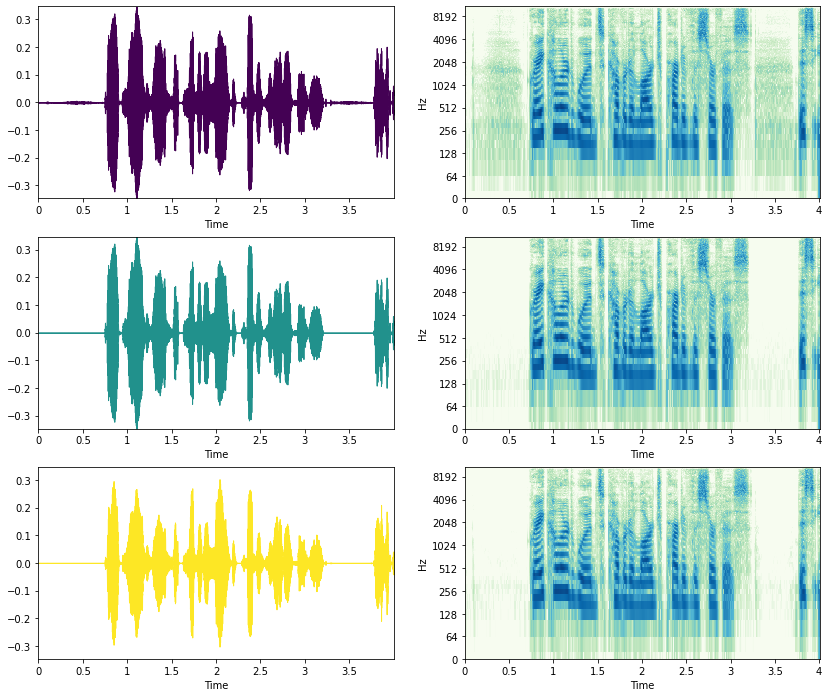

In [28]:
utils.plotTimeFreq([x, y, z], kSR)

In [29]:
ipd.Audio(x, rate=kSR) # This player normalizes input arrays

In [30]:
ipd.Audio(y, rate=kSR) # Target

In [31]:
ipd.Audio(z, rate=kSR) # Ouput

In [33]:
# This applies to the parameters of the icassp submission

parameterName = []
p_plot = []
if kTask == 'nonspeech':
    params = ['th-1', 'ratio-1', 'makeup_gain-1',
                     'th-2', 'ratio-2', 'makeup_gain-2',
                     'th-3', 'ratio-3', 'makeup_gain-3',
                     'th-4', 'ratio-4', 'makeup_gain-4',
                     'freq1','freq2', 'freq3',
                     'input_gain', 'output_gain'
                    ]
    parameterName.append(params)
    
elif kTask == 'distortion':
    params = ['threshold-1', 'ratio-1', 'makeup_gain-1', 'knee-1',
                 'threshold-2', 'ratio-2', 'makeup_gain-2', 'knee-2',
                 'threshold-3', 'ratio-3', 'makeup_gain-3', 'knee-3',
                 'th-4', 'ratio-4', 'gain-4', 'knee-4',
                 'freq1','freq2', 'freq3',
                 'input_gain', 'output_gain'
                ]
    parameterName.append(params)
    
elif kTask == 'mastering':
    params = ['threshold-1', 'ratio-1', 'makeup_gain-1',
                 'threshold-2', 'ratio-2', 'makeup_gain-2', 
                 'threshold-3', 'ratio-3', 'makeup_gain-3',
                 'threshold-4', 'ratio-4', 'makeup_gain-4', 
                 'freq1','freq2', 'freq3',
                 'input_gain', 
                ]

    parameterName.append(params)

    params = list(range(kParams[1]))
    parameterName.append(params)
    
    params = ['threshold']
    parameterName.append(params)
    

parameterNames = [item for sublist in parameterName for item in sublist]

t_audio = librosa.core.samples_to_time(np.linspace(0,len(x)-1,len(x)),
                                  sr=kSR)


In [34]:
def export_legend(legend, filename, expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))


<Figure size 1152x504 with 0 Axes>

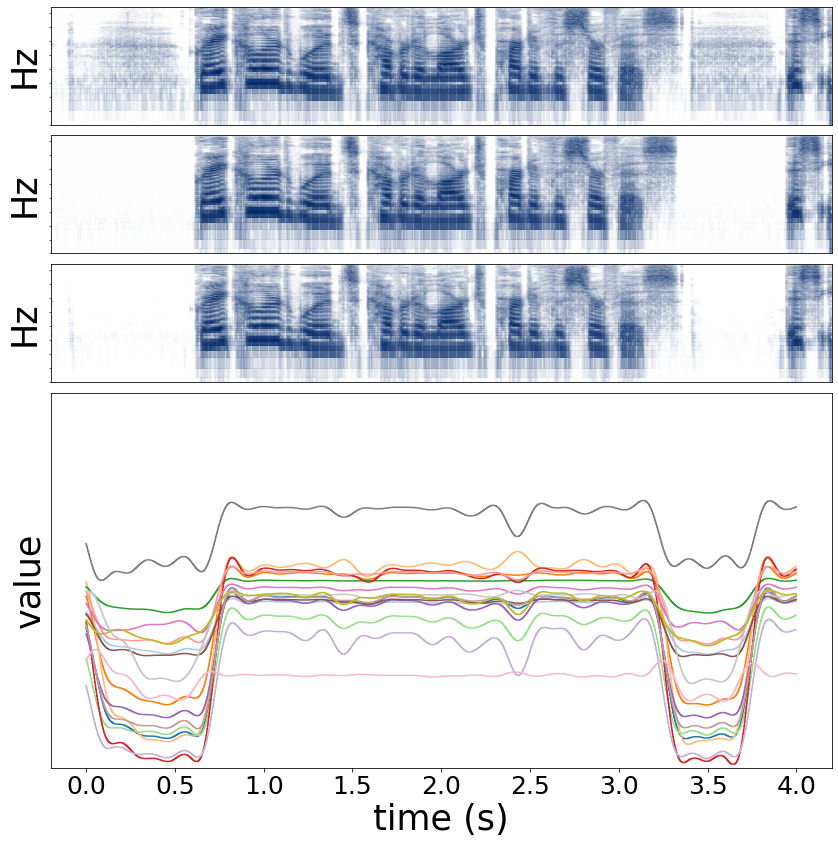

<Figure size 1008x1008 with 0 Axes>

plots saved


In [35]:
# Plot input, target, output spectrograms and parameters

fig = plt.figure()
# plt.figure(figsize=(14, 6))
plt.rcParams['figure.figsize'] = (14,14)
plt.rcParams["axes.facecolor"]= 'w'
plt.rcParams["axes.edgecolor"] = 'k'
plt.rcParams["savefig.dpi"] = 200
kFont = 35
kTick = 25
save = True
from matplotlib.pylab import register_cmap, rc
cdict = {
    'red':   ((0.0,  1.0, 1.0), (1.0,  0.0, 0.0)),
    'green': ((0.0,  1.0, 1.0), (1.0,  .15, .15)),
    'blue':  ((0.0,  1.0, 1.0), (1.0,  0.4, 0.4)),
    'alpha': ((0.0,  0.0, 0.0), (1.0,  1.0, 1.0))}
register_cmap(name='InvBlueA', data=cdict)
sr = kSR
n_fft=512
hop_length=128
CMAPS = 'InvBlueA'

# Plots spectrograms
audio = [x,y,z]
n = len(audio)
X = []
X_db = []
maxs = np.zeros((n,))
mins = np.zeros((n,))
maxs_t = np.zeros((n,))
for i, x_ in enumerate(audio):
    X_ = librosa.stft(x_, n_fft=n_fft,hop_length=hop_length)
    X_db_ = librosa.power_to_db(abs(X_)**2)
    X.append(X_)
    X_db.append(X_db_)
    maxs[i] = np.max(X_db_)
    mins[i] = np.min(X_db_)
    maxs_t[i] = np.max(np.abs(x_))
vmax = np.max(maxs)
vmin = np.min(mins)
tmax = np.max(maxs_t)
fig = plt.figure()
ax_ = fig.add_subplot(111)
for i in range(n):
    ax = plt.subplot2grid((12, 1), (i*2, 0), rowspan=2)
    librosa.display.specshow(X_db[i], sr=sr, x_axis=None, y_axis='log',
                             hop_length=hop_length, cmap=CMAPS, vmax=vmax, vmin=vmin)
    plt.ylabel('Hz',fontsize=kFont)
    ax.set_yticks([])

# Plots parameters
ax = plt.subplot2grid((12, 1), (6, 0), rowspan=6)
j=0
idx = 0

for i in range(np.sum(kParams)):
    p = np.repeat(parameters[:,i], kBlockSize)
    plt.plot(t_audio, p[sec1:sec2],
             '-',
             label=parameterNames[i],
             linewidth=1.5, alpha=1, 
            color=plt.cm.tab20(i%20))

plt.xlabel('time (s)',fontsize=kFont)
plt.ylabel('value',fontsize=kFont)
ax.set_yticks([])
plt.ylim(-0.01,1.01)

plt.xticks(fontsize=kTick)
plt.yticks(fontsize=kTick)
ax_.set_yticks([])
ax_.set_xticks([])
ax_.spines['top'].set_visible(False)
ax_.spines['right'].set_visible(False)
ax_.spines['bottom'].set_visible(False)
ax_.spines['left'].set_visible(False)
plt.show()
plt.tight_layout()
if save:
    fig.savefig(kTestAudio+kFullModel+f'_{kIdTrack}_plots.pdf',
                format='PDF', transparent = False, dpi=200)
    # Saves legend in different plot
    lgd = ax.legend(loc=1, bbox_to_anchor=(1.05, -0.5),
                fontsize=kTick, ncol=4,
                borderpad=0.2,handletextpad=0.1,handlelength=0.9)
    export_legend(lgd,kTestAudio+kFullModel+f'_{kIdTrack}_plots_legend.pdf')
    plt.close(fig)
    print('plots saved')